In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from fuzzywuzzy import fuzz

import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

C:\Users\onlyt\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [3]:
def save_pickle(data, path):
    data.to_pickle(path)
def load_pickle(path):
    return pd.read_pickle(path)
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
def load_model(filename):
    # load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [1]:
def make_title(article):
    csr = tfidf.fit_transform([article])
    
    csr = pd.Series(list(csr.toarray().reshape(-1,1)))
    csr.index = tfidf.get_feature_names()
    csr_sorted_id = csr.sort_values().index
    csr_sorted = csr.sort_values()
    
    title = ''
    counter = 0
    for i in range(len(csr_sorted_id)):
        if counter == 3:
            return title
        else:
            if csr_sorted_id[-(i+1)] not in err_words:
                title += ' '+csr_sorted_id[-(i+1)]
                counter+=1

In [2]:
def make_title_from_bagOfWords(article):
    tokens = word_tokenize(article)
    lower_tokens = [t.lower() for t in tokens]
    
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stop_words]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    
    title = ""
    bow = Counter(lemmatized)
    for i in bow.most_common(3):
        title+= ' '+ i[0]
    return title

In [ ]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [ ]:
def elbow(csr, a, b):
    ks = range(a, b)
    inertias = []
    
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(csr)
        inertias.append(model.inertia_)
        
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    return inertias

In [ ]:
def make_category(df):
    for i in np.unique(df.TfidVec_title_clustering):
        corpus = df[df['TfidVec_title_clustering'] == i].title2
        vec = CountVectorizer(stop_words=stop_words).fit(corpus)
        bag_of_words = vec.transform(corpus)

        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

        category_name = ''
        for word in range(3):
            if word == 2:
                category_name += words_freq[word][0]
            else:
                category_name += words_freq[word][0] + '-'
        df.loc[df.TfidVec_title_clustering == i, 'Category'] = category_name

### First look on data

In [4]:
wiki_doc = pd.read_csv(r'documents_utf8_filtered_20pageviews.csv',engine='python', nrows=200000)

In [11]:
new_columns = ['article_id', 'text']

In [12]:
wiki_doc.rename(columns = {wiki_doc.columns[0] : new_columns[0],
                          wiki_doc.columns[1] : new_columns[1]}, inplace=True)

In [13]:
wiki_doc.head()

,article_id,text
0,wikipedia-23885928,The Death of Bunny Munro The Death of Bunny ...
1,wikipedia-23886057,Management of prostate cancer Treatment for ...
2,wikipedia-23886425,Cheetah reintroduction in India Reintroducti...
3,wikipedia-23886491,Langtang National Park The Langtang National...
4,wikipedia-23886546,Shivapuri Nagarjun National Park Shivapuri N...


### Words that we don't want during processing

In [63]:
err_words = ['from', 'about', 'after', 'also', 'although', 
            'back', 'based', 'became', 'been', 'called', 'even',
            'five', 'from', 'have','however','include','later',
            'more','most','only','other','over','received','some',
            'that','their','then','these','third','this','three',
            'until','well','were','which','with','would','often','they',
            'lszc','mine', 'last', 'runs', 'fault', 'luzon' ,'benmosche',
            'shown', 'one', 'new']
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(err_words)

### Word frequency matrix (TfidVectorizer)

In [15]:
tfidf = TfidfVectorizer(
    analyzer="word",
    token_pattern=r'\w{4,}',
    min_df = 0.2, 
    strip_accents='unicode',
    stop_words=stop_words) 

### Make title using TfidVectorizer (one TfidVectorizer model on each article)

In [17]:
wiki_doc['title'] = [make_title(wiki_doc.iloc[i, 1]) for i in range(wiki_doc.shape[0])]

In [18]:
wiki_doc.head()

,article_id,text,title
0,wikipedia-23885928,The Death of Bunny Munro The Death of Bunny ...,novel cave nick
1,wikipedia-23886057,Management of prostate cancer Treatment for ...,prostate cancer radiation
2,wikipedia-23886425,Cheetah reintroduction in India Reintroducti...,india cheetah asiatic
3,wikipedia-23886491,Langtang National Park The Langtang National...,park national langtang
4,wikipedia-23886546,Shivapuri Nagarjun National Park Shivapuri N...,park area himalayan


### Creating titles using bag of words aprroach

In [21]:
wiki_doc['title2'] = [make_title_from_bagOfWords(wiki_doc.iloc[i, 1]) for i in range(wiki_doc.shape[0])]

In [22]:
wiki_doc.head(5)

,article_id,text,title,title2
0,wikipedia-23885928,The Death of Bunny Munro The Death of Bunny ...,novel cave nick,novel bunny nick
1,wikipedia-23886057,Management of prostate cancer Treatment for ...,prostate cancer radiation,prostate cancer radiation
2,wikipedia-23886425,Cheetah reintroduction in India Reintroducti...,india cheetah asiatic,cheetah india asiatic
3,wikipedia-23886491,Langtang National Park The Langtang National...,park national langtang,park national langtang
4,wikipedia-23886546,Shivapuri Nagarjun National Park Shivapuri N...,park area himalayan,park area indian


### Make title using TfidVectorizer (TfidVectorizer model on all articles)

In [24]:
csr_mat = tfidf.fit_transform(wiki_doc.iloc[:, 1])

### SVD

In [25]:
svd = TruncatedSVD(n_components=csr_mat.shape[1]-1)
svd.fit(csr_mat)

TruncatedSVD(algorithm='randomized', n_components=76, n_iter=5,
       random_state=None, tol=0.0)

In [27]:
n = select_n_components(svd.explained_variance_ratio_,0.90)
svd = TruncatedSVD(n_components= n)
csr_svd = svd.fit_transform(csr_mat)

### KMeans - elbow method to choose the best "k" parameter

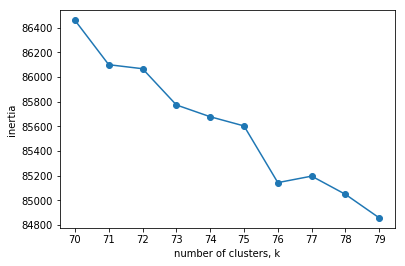

In [121]:
# inertias = []
next_inertias = elbow(csr_svd)
inertias += next_inertias

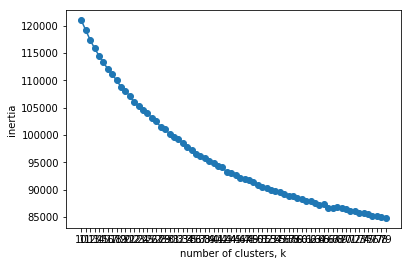

In [123]:
ks = range(10,80)
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Clustering

In [29]:
number_of_clusters = 65
kmeans = KMeans(n_clusters = number_of_clusters)
kmeans.fit(csr_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=65, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Predicting

In [32]:
labels = kmeans.predict(csr_svd)

In [33]:
wiki_doc['TfidVec_label'] = labels

In [24]:
wiki_doc[wiki_doc.TfidVec_label == 3].head()

,article_id,text,title,title2,TfidVec_label
43,wikipedia-24103304,"Glossary of HVAC terms HVAC (heating, ventil...",hvac glossary terms,hvac glossary term,3
397,wikipedia-219424,Sergeant Sergeant (normally abbreviated to S...,sergeant rank army,sergeant rank army,3
402,wikipedia-219498,Sadism and masochism in fiction The role of ...,janice films fiction,fiction film janice,3
931,wikipedia-20193727,Design basis accident A design basis acciden...,design basis accident,accident design basis,3
1096,wikipedia-16407460,Endogenous depression Endogenous Depression ...,depression endogenous disorder,depression endogenous disorder,3


In [63]:
clusters = []
for i in range(number_of_clusters):
    clusters.append(df[df.iloc[:,1] == i])

In [65]:
merging_clusters = []
for cluster in clusters:
    merging_clusters.append(cluster.merge(wiki_doc.iloc[:, :], left_on='article_id', right_on='article_id'))

In [67]:
tfidfc = TfidfVectorizer(
    analyzer="word",
    token_pattern=r'\w{4,}',
    min_df = 0.2, 
    strip_accents='unicode')

In [ ]:
n = 10
for i in range(len(merging_clusters)):
    cl0wf = tfidfc.fit_transform(merging_clusters[i].iloc[:,2])
    feature_array = np.array(tfidfc.get_feature_names())
    tfidf_sorting = np.argsort(cl0wf.toarray()).flatten()[::-1]
    print('Cluster '+str(i)+' 10 common words: \n', feature_array[tfidf_sorting][:n])

### Clustering on TfidVec titles

In [75]:
tfidf_title2 = TfidfVectorizer(
    analyzer="word",
    token_pattern=r'\w{4,}',
    strip_accents='unicode') 

In [76]:
csr_mat_title2 = tfidf_title2.fit_transform(wiki_doc.iloc[:, 3]) 

In [78]:
kmeans_title = KMeans(n_clusters = 65)
kmeans_title.fit(csr_mat_title2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=65, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [79]:
wiki_doc['TfidVec_title_clustering'] = kmeans_title.predict(csr_mat_title2)

### Make category - BagOfWords

In [82]:
make_category(wiki_doc)

In [85]:
new_columns = ['article_id', 'article',
               'title1', 'title2',
               'article_cluster', 'title2_cluster', 'title2_category',
               'title1_cluster', 'title1_category']
wiki_doc.columns = new_columns

In [40]:
wiki_doc.columns = ['ID',
                   'Article',
                   'Freq_title',
                   'Bag_title',
                   'Bag_cluster',
                   'Bag_category',
                   'Freq_cluster',
                   'Freq_category',
                   'Category']

### Examples

In [45]:
wiki_doc[wiki_doc.Bag_cluster == 10][['Article', 'Bag_title', 'Bag_cluster', 'Bag_category']].head().to_excel('category_name.xlsx')

In [48]:
wiki_doc[wiki_doc.Freq_cluster == 9][['Article', 'Freq_title', 'Freq_cluster', 'Freq_category']].head().to_excel('category_name2.xlsx')

In [55]:
wiki_doc[wiki_doc.Bag_cluster == 10][['Article', 'Freq_category', 'Bag_category', 'Category']].head().to_excel('category_final.xlsx')

In [62]:
category_info = {}
for i in pd.unique(wiki_doc.Category):
    category_info[i] = wiki_doc[wiki_doc.Category == i].shape[0]

In [65]:
import operator
cat_sorted = dict(sorted(category_info.items(), key=operator.itemgetter(1)))

In [68]:
max_key = 10
for i in list(cat_sorted.keys())[::-1]:
    if max_key == 0:
        break
    else:
        print(i, category_info[i])
        max_key -=1

world war episode book film town 87020
world war episode university club island 10369
film role movie award 4786
school club role university island 4181
school club role book film town 4085
album single track song 2570
band album tour song 2231
city area century town 1675
song single video album 1650
series episode role film 1620


### Conecting category names into one combined category

In [19]:
wiki_doc["Category"] = wiki_doc["title2_category"].map(str) + '-' + wiki_doc["title1_category"].map(str)

In [20]:
wiki_doc["Category"] = wiki_doc["Category"].apply(lambda x: ' '.join(pd.unique(x.split('-'))))